# Определение стоимости автомобилей

Мною была разработана система рекомендации стоимости автомобиля на основе его описания

## Импорт библиотек и определение констант <a id="section1"></a>

In [1]:
#!pip install lightgbm
!pip install category-encoders

In [2]:
from tqdm.notebook import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import sweetviz as sv

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from category_encoders import TargetEncoder

**config**

In [3]:
RANDOM_STATE = 12345

## Подготовка данных <a id="section1"></a>

### Выгрузка данных

In [ ]:
try:
    data = pd.read_csv('../datasets/autos1.csv')
except:
    pass

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Видно что есть пропуски, но форматы, но некоторые типы данных выбраны неверно. Repaired толжен быть тип значений Bool. П

In [6]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
data.describe(include = 'object' )

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,Repaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


In [8]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### Очистка данных

Fast EDA

In [9]:
# analyze_report = sv.analyze(data)
# analyze_report.show_html('report.html', open_browser=True)

#### Удаление ненужных столбцов

- Удалим столбец `NumberOfPictures`, так как все его значения равны нулю. (mean и std равны нулю)

In [10]:
data = data.drop(columns=['NumberOfPictures'])

- Удалим столбец `PostalCode`. Слишком много уникальных значений, и нельзя по ним точно определить координаты и упростить 'PostalCode' в более простые классы

Да из интернета можно узнать, что первые три цифры соответствуют региону [Статья википедии](https://ru.wikipedia.org/wiki/%D0%9F%D0%BE%D1%87%D1%82%D0%BE%D0%B2%D0%BE%D0%B5_%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8)

Но региона 999 нету, так что скорее всего данные закодированы и это нам ничем не поможет без дополнительных данных

In [11]:
data['PostalCode'].nunique()

8143

In [12]:
data = data.drop(columns=['PostalCode'])

- `DateCrawled`, `DateCreated`, `LastSeen`

По идее эти столбцы могут нам помочь. Ведь объявление может быть составлено и выгружен в разное время. Проверим диапазон дат и далее примем решение, будем ли мы учитывать эти данные

***DateCrawled***

In [13]:
min(data['DateCrawled']) , max(data['DateCrawled'])

('2016-03-05 14:06:22', '2016-04-07 14:36:58')

Данные были скачаны в течении одного месяца в 2016 году. Они нам существенно не помогут. Но эти данные стоит учитывать при дальнейшем использовании модели, когда мы будем выкатывать модель в продакшн

In [14]:
data = data.drop(columns=['DateCrawled'])

***DateCreated***

In [15]:
min(data['DateCreated']) , max(data['DateCreated'])

('2014-03-10 00:00:00', '2016-04-07 00:00:00')

Диапазон создания с 2014 по 2016 год

In [16]:
data['DateCreated'] = pd.to_datetime(data['DateCreated'])

In [17]:
data['YearCreated'] = data['DateCreated'].dt.year

In [18]:
data = data.drop(columns=['DateCreated'])

Не будем использовать месяц, возьмём только год создания

***LastSeen***

In [19]:
min(data['LastSeen']) , max(data['LastSeen'])

('2016-03-05 14:15:08', '2016-04-07 14:58:51')

Данные тоже больше для проверки, а не для построения модели. То есть мы убедились, что пользователи и данные актуальные

In [20]:
data = data.drop(columns=['LastSeen'])

#### Приведение к нужному типу

In [21]:
data['Gearbox'].value_counts()

manual    268251
auto       66285
Name: Gearbox, dtype: int64

Заменим `Gearbox` на тип bool, так как признаков два

Все остальные данные соответствуют типам, кроме `Repaired`. Но мы поменяем тип после заполнения пропусков. 

In [22]:
data['AutoGearbox'] = data['Gearbox'] == 'auto'

In [23]:
data = data.drop(columns = 'Gearbox')

#### Заполнение пропусков

В LightGBM можно передавать пропущенные значения, как и в CatBoost. Также можно передавать пропущенные значения и алгоритм из сам заполнит

Поэтому сделаем два датасета. Один для бустингового алгоритма, второй для другой модели

In [24]:
(pd.concat([data.isna().sum(), 
           np.round(data.isna().sum() / data.shape[0] * 100,2),], axis = 1)
             .rename(columns = {0:'miss_values', 1:'per_miss'}))

,miss_values,per_miss
Price,0,0.00
VehicleType,37490,10.58
RegistrationYear,0,0.00
Power,0,0.00
Model,19705,5.56
Kilometer,0,0.00
RegistrationMonth,0,0.00
FuelType,32895,9.28
Brand,0,0.00
Repaired,71154,20.08


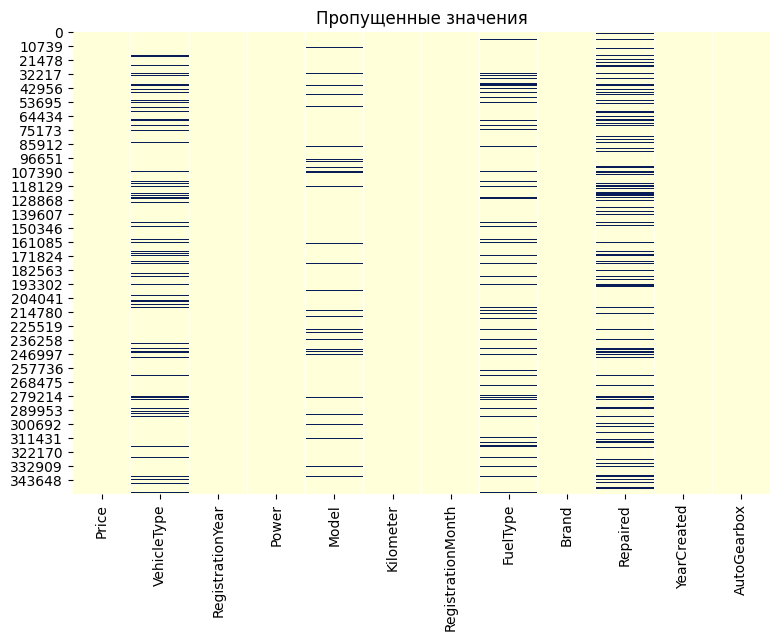

In [25]:
plt.figure(figsize=(9,6))
sns.heatmap(data.isna(),
            cmap="YlGnBu",cbar = False)
plt.title('Пропущенные значения')
plt.show()

Перед заполнением пропусков сохраним данные для бустинговых алгоритмов, которые прогоним отдельно без предобработки

In [26]:
data_for_boost = data.copy()

In [27]:
for col in data_for_boost.columns:
    col_type = data_for_boost[col].dtype
    if col_type == 'object' or col_type.name == 'category':
        data_for_boost[col] = data_for_boost[col].astype('category')

In [28]:
data_for_boost.head()

,Price,VehicleType,RegistrationYear,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,YearCreated,AutoGearbox
0,480,NaN,1993,0,golf,150000,0,petrol,volkswagen,NaN,2016,False
1,18300,coupe,2011,190,NaN,125000,5,gasoline,audi,yes,2016,False
2,9800,suv,2004,163,grand,125000,8,gasoline,jeep,NaN,2016,True
3,1500,small,2001,75,golf,150000,6,petrol,volkswagen,no,2016,False
4,3600,small,2008,69,fabia,90000,7,gasoline,skoda,no,2016,False


- VehicleType — тип автомобильного кузова

In [29]:
data['VehicleType'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

Введём новый признак 'nothing' и заменим на него

In [30]:
data['VehicleType'] = data['VehicleType'].fillna('nothing')

- Model — модель автомобиля

In [31]:
data['Model'].value_counts()

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
rangerover                4
serie_3                   4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64

С моделью сложнее, так как существует около 250 моделей. Для этого отберем топ 10 заполненный моделей. А остальные отнесём в 'other'

In [32]:
model_top = data['Model'].value_counts()[:10].index

In [33]:
data.loc[~data['Model'].isin(model_top),'Model'] = 'other'

- FuelType — тип топлива. Меняем на медиану, если не указывают тип топлива, скорее всего бензин. В других случаях бы указали

In [34]:
data['FuelType'] = data['FuelType'].fillna(data['FuelType'].mode().values[0])

- Repaired — была машина в ремонте или нет. Если не указано, то скорее всего нет. Данный факт проверить нет возможности. Меняем на нет и переводим в тип bool

In [35]:
data['Repaired'].value_counts()

no     247161
yes     36054
Name: Repaired, dtype: int64

In [36]:
data['Repaired'] = data['Repaired'].fillna('no') == 'yes'

#### Выбросы и неадекватные значения

**Год регистрации автомобиля**

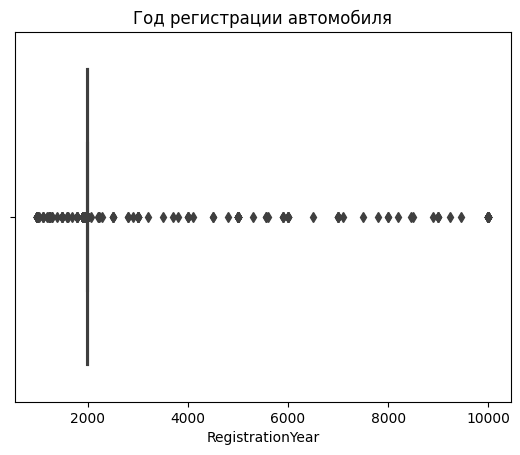

In [37]:
sns.boxplot(x = data['RegistrationYear'])
plt.title('Год регистрации автомобиля')
plt.show()

In [38]:
data['RegistrationYear'][data['RegistrationYear'] < 1900].unique()

array([1111, 1000, 1500, 1800, 1234, 1400, 1200, 1255, 1001, 1688, 1253,
       1600, 1039, 1300, 1602], dtype=int64)

Итого нижний предел ставим 1900, верхний 2016 годь

In [39]:
data['RegistrationYear'] = data['RegistrationYear'].clip(
                                        lower=1900 , upper=2016)
data_for_boost['RegistrationYear'] = data_for_boost['RegistrationYear'].clip(
                                        lower=1900 , upper=2016)

Второй вариант, это привести такие неадекватные значения к медиане, но остановимся на первом варианте. Дублируем действия для второго датасета

**Мощность**

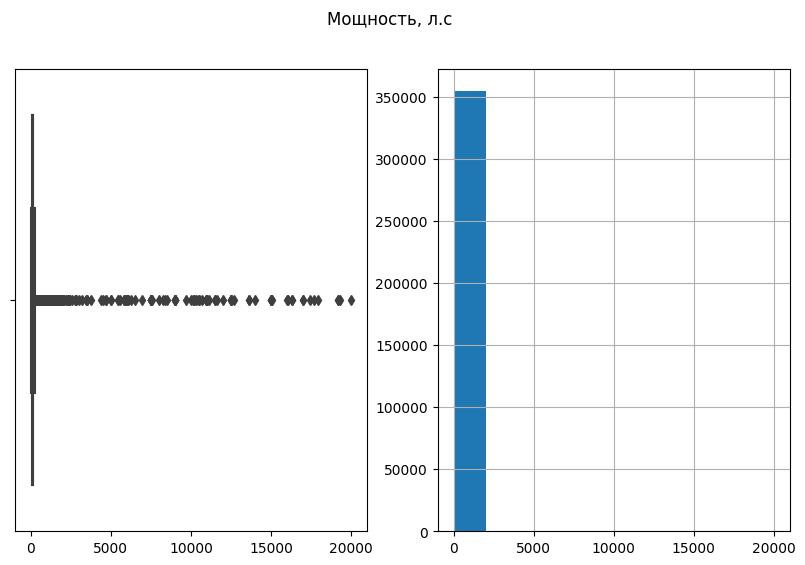

In [40]:
fig, ax = plt.subplots(1,2, figsize = (10,6))
fig.suptitle('Мощность, л.с')

sns.boxplot(x = data['Power'], ax = ax[0])
ax[0].set_xlabel('')

data['Power'].hist(ax = ax[1])
plt.show()

Максимальная мощность составляее 2000 л.с. Очевидно те значения, которые больше неверно занесены с ошибкой. Разделим их на 10

In [41]:
data.loc[data['Power'] > 2000, 'Power'] =  \
data.loc[data['Power'] > 2000, 'Power'] / 10

In [42]:
data_for_boost.loc[data_for_boost['Power'] > 2000, 'Power'] =  \
data_for_boost.loc[data_for_boost['Power'] > 2000, 'Power'] / 10

<AxesSubplot:>

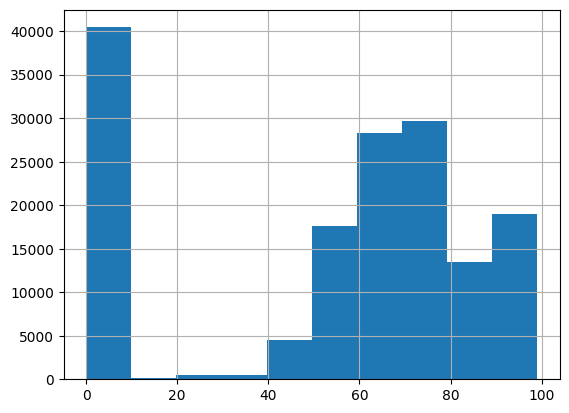

In [43]:
data[data['Power'] < 100]['Power'].hist()

Мощность меньше 20 л.с. Кажется подозрительной, вряд ли есть такие авто

In [44]:
data[data['Power'] < 20]

,Price,VehicleType,RegistrationYear,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,YearCreated,AutoGearbox
0,480,nothing,1993,0.0,golf,150000,0,petrol,volkswagen,False,2016,False
15,450,small,1910,0.0,other,5000,0,petrol,ford,False,2016,False
32,245,sedan,1994,0.0,golf,150000,2,petrol,volkswagen,False,2016,False
37,1500,nothing,2016,0.0,other,150000,1,gasoline,renault,False,2016,False
40,0,nothing,1990,0.0,corsa,150000,1,petrol,opel,False,2016,False
...,...,...,...,...,...,...,...,...,...,...,...,...
354346,2600,nothing,2005,0.0,c_klasse,150000,9,petrol,mercedes_benz,False,2016,True
354360,3999,wagon,2005,3.0,3er,150000,5,gasoline,bmw,False,2016,False
354363,1150,bus,2000,0.0,other,150000,3,petrol,opel,False,2016,False
354364,0,nothing,2005,0.0,other,150000,7,petrol,mitsubishi,True,2016,False


Мощность была указана неправильно. Заменим их медианой по дате регистрации

In [45]:
data.loc[data['Power'] < 20, 'Power'] = data['Power'].median()
data_for_boost.loc[data_for_boost['Power'] < 20, 'Power'] = data['Power'].median()

**Пробег автомобиля**

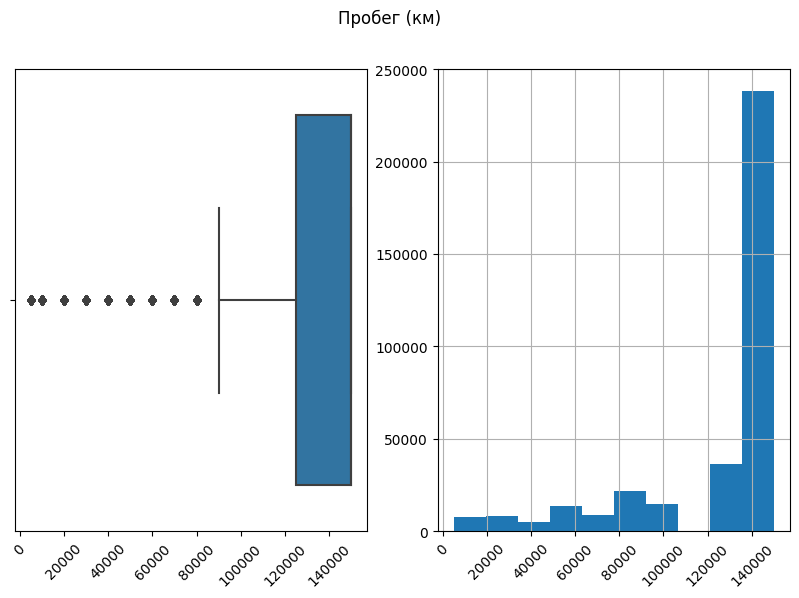

In [46]:
fig, ax = plt.subplots(1,2, figsize = (10,6))
fig.suptitle('Пробег (км)')

sns.boxplot(x = data['Kilometer'], ax = ax[0])
ax[0].set_xlabel('')
ax[0].tick_params(axis='x', labelrotation=45)

data['Kilometer'].hist(ax = ax[1])
ax[1].tick_params(axis='x', labelrotation=45)
plt.show()

В целом данные актуальны, в сервисе продажи автомобилей с пробегом в основном такие авто

### Проверка на дубликаты

In [47]:
data.duplicated().sum()

35217

In [48]:
data = data.drop_duplicates()

In [49]:
data_for_boost = data_for_boost.drop_duplicates()

Дубликаты удалены

### Матрица корреляций

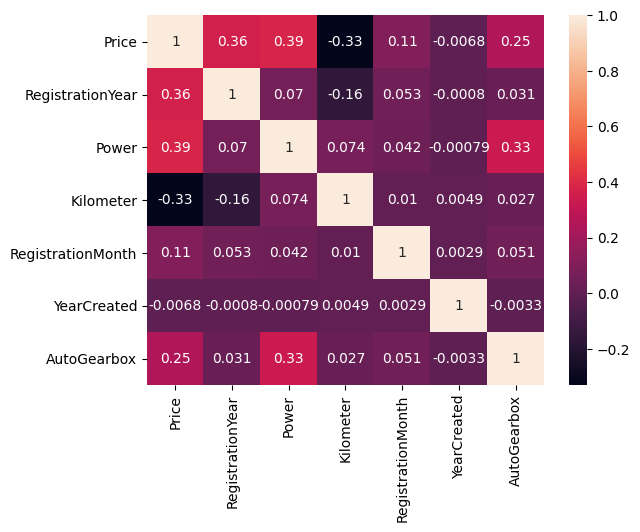

In [50]:
sns.heatmap(data_for_boost.corr(), annot = True)
plt.show()

Мы видим, что сильной корреляции не наблюдается и линейных зависимостей между переменными нет

### PairPlot

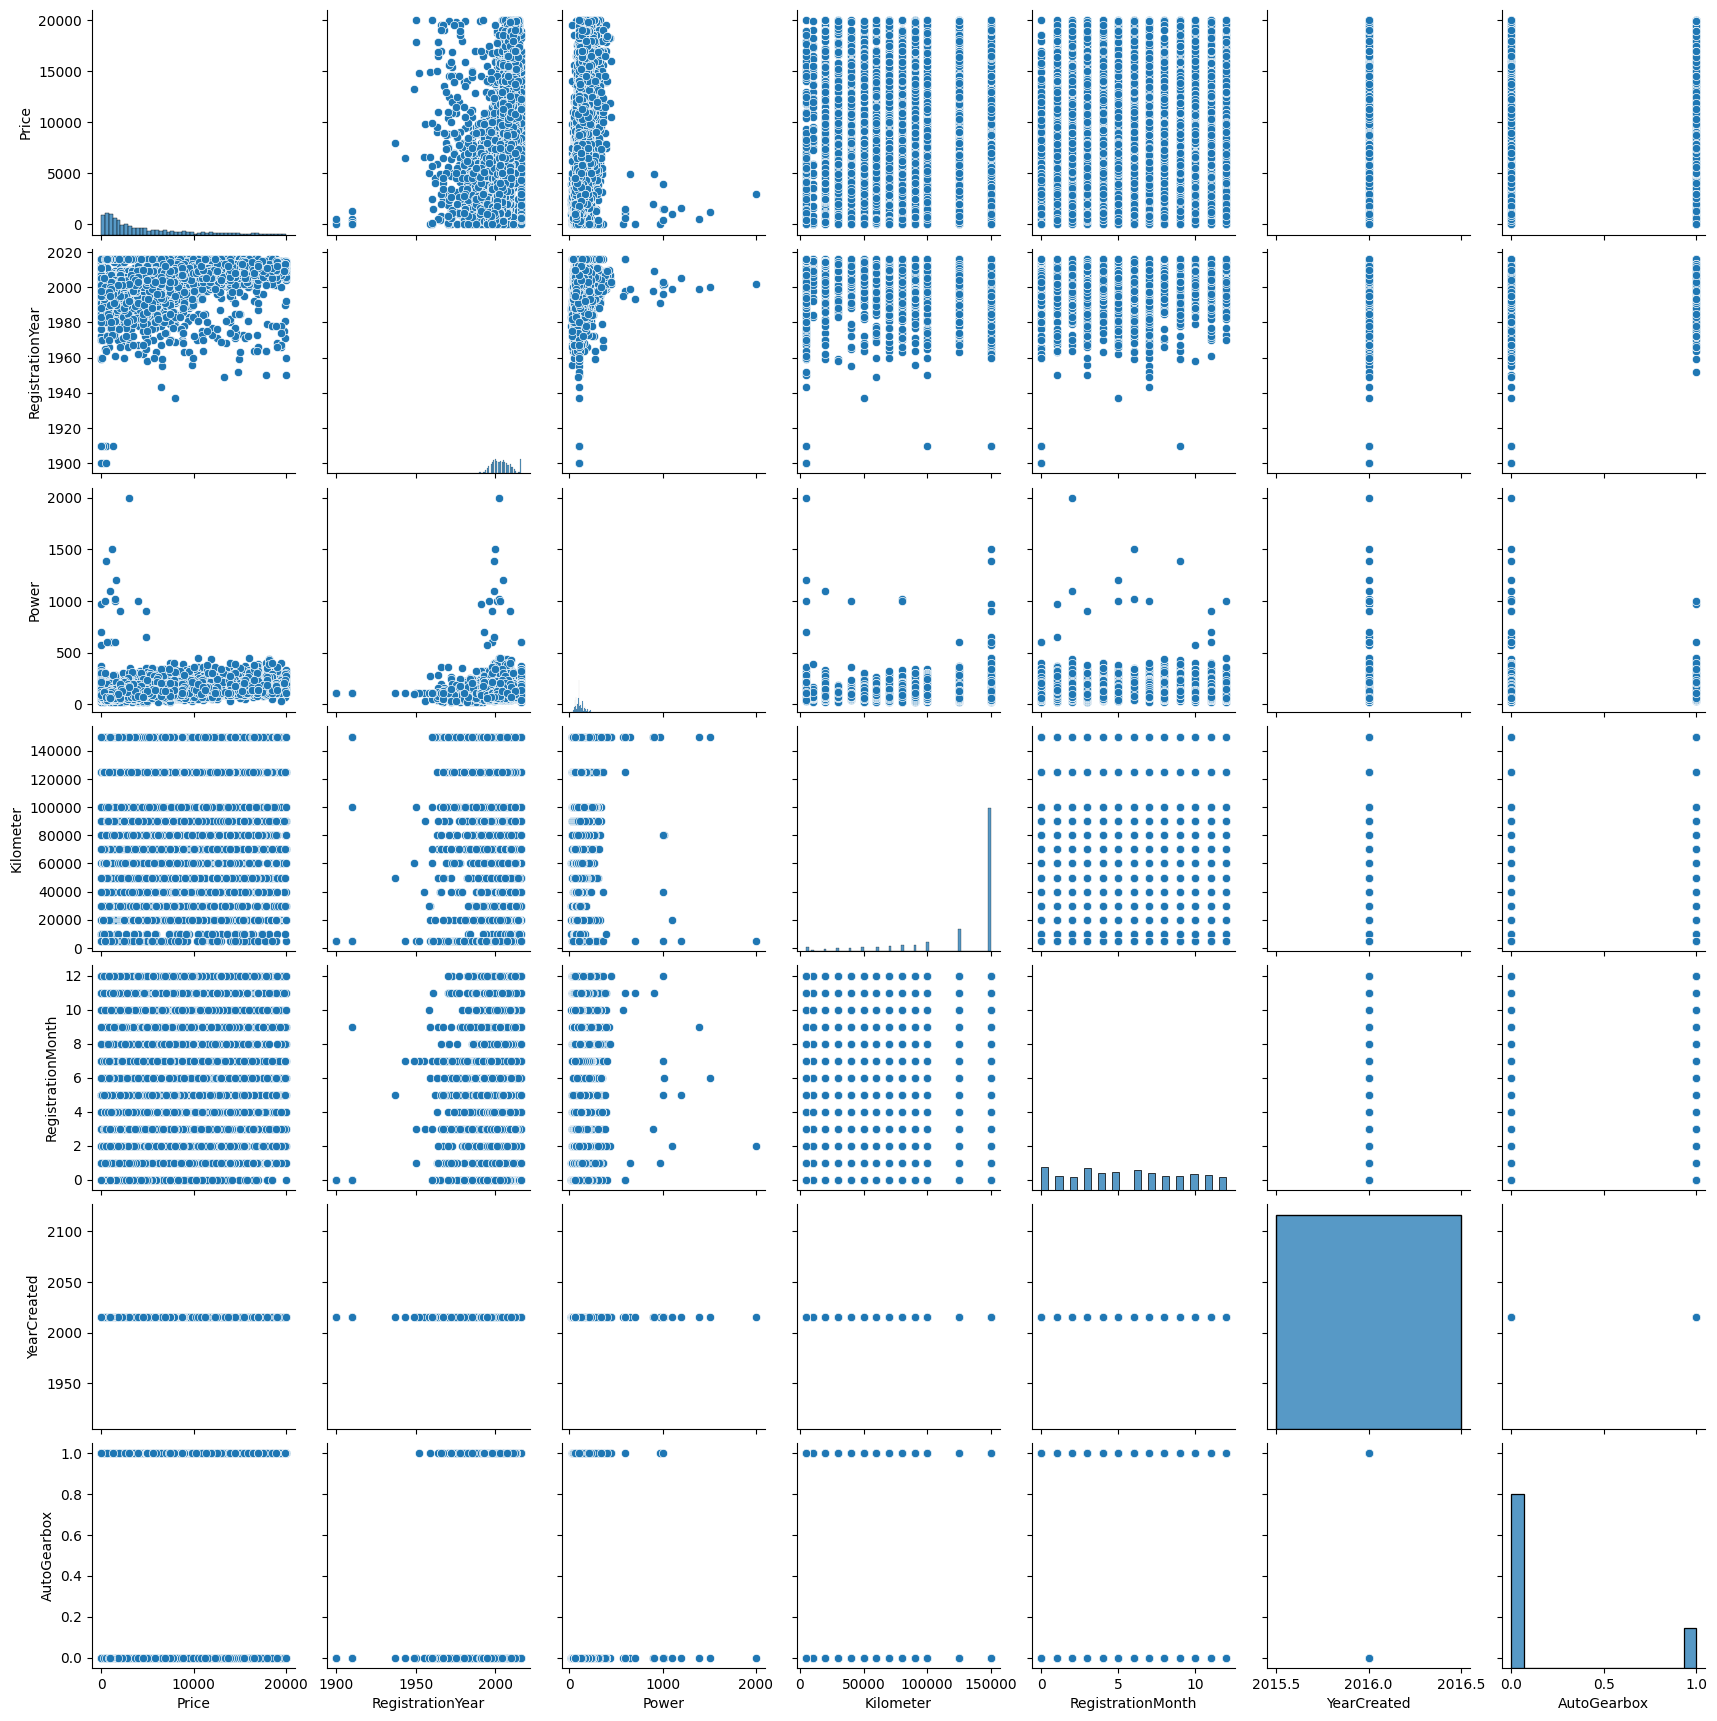

In [51]:
sns.pairplot(data_for_boost.sample(frac = 0.05))
plt.show()

Мы видим несколько зависимостей:

- Максиимальные значения лошадиных сил растут с увеличением года выпуска
- С ценой тоже наблюдается что-то похожее. Но есть ряд точек, которые выбиваются из общей тендеции

### Страндартизация, разделение на train, test

#### Разделение данных

In [52]:
data_features = data.drop(columns=['Price'])
data_target = data['Price']

data_b_features = data_for_boost.drop(columns=['Price'])
data_b_target = data_for_boost['Price']

Итого делим выборки на тренировочную, вадидационную и тестовую

In [53]:
data_features_train, data_features_valid, data_target_train, data_target_valid = \
train_test_split(data_features, data_target, test_size = .40, 
                 random_state = RANDOM_STATE)

data_features_valid, data_features_test, data_target_valid, data_target_test = \
train_test_split(data_features_valid, data_target_valid, test_size = .50, 
                 random_state = RANDOM_STATE)


data_b_features_train, data_b_features_valid, data_b_target_train, data_b_target_valid = \
train_test_split(data_b_features, data_b_target, test_size = .40, 
                 random_state = RANDOM_STATE)

data_b_features_valid, data_b_features_test, data_b_target_valid, data_b_target_test = \
train_test_split(data_b_features_valid, data_b_target_valid, test_size = .50, 
                 random_state = RANDOM_STATE)


#### Работа с категориальными признаками

Кроме бустингового алгоритма мы будем использовать стандартные модели и они так просто не "проглатывают" категориальные данные

Преобразуем их через OneHotEncoding

In [54]:
transformer_TE = make_column_transformer(
    (TargetEncoder(handle_unknown = 'ignore'), 
     ['VehicleType','Model','FuelType','Brand']),
    remainder='passthrough')

transformer_TE.fit(data_features_train, data_target_train)

data_features_train_TE = pd.DataFrame(
    data = transformer_TE.transform(data_features_train), 
    columns=data_features_train.columns
)

data_features_valid_TE = pd.DataFrame(
    data = transformer_TE.transform(data_features_valid), 
    columns=data_features_valid.columns
)


data_features_test_TE = pd.DataFrame(
    data = transformer_TE.transform(data_features_test), 
    columns=data_features_test.columns
)

#### Стандартизация

In [55]:
scaler = StandardScaler()

In [56]:
scaler.fit(data_features_train_TE)

data_features_train_TE = pd.DataFrame(
    data = scaler.transform(data_features_train_TE), 
    columns=data_features_train_TE.columns
)

data_features_valid_TE = pd.DataFrame(
    data = scaler.transform(data_features_valid_TE), 
    columns=data_features_valid_TE.columns
)

data_features_test_TE = pd.DataFrame(
    data = scaler.transform(data_features_test_TE), 
    columns=data_features_test_TE.columns
)

## Обучение моделей <a id="section2"></a>

#### Линейная регрессия с регуляризацией и гиперпараметрами

In [57]:
for ratio in np.arange(0.1,1,0.1):
    model_elastic = ElasticNet( l1_ratio=ratio,
                                 alpha = 0.8,
                                 random_state = RANDOM_STATE)
    model_elastic.fit(data_features_train_TE, data_target_train)
    predict_el = model_elastic.predict(data_features_valid_TE)
    print(mean_squared_error(data_target_valid, predict_el, squared=False), end = '')
    print('   ', ratio)

3322.8302304916488    0.1
3296.8162235576206    0.2
3270.5160043888645    0.30000000000000004
3244.2001847451775    0.4
3218.296588722684    0.5
3193.3484133403767    0.6
3170.2553565311164    0.7000000000000001
3150.337467843793    0.8
3135.6153378123845    0.9


In [58]:
%%time
model_elastic = ElasticNet( l1_ratio=0.9,
                                 alpha = 0.8,
                                 random_state = RANDOM_STATE)

model_elastic.fit(data_features_train_TE, data_target_train)

CPU times: total: 141 ms
Wall time: 94.7 ms


ElasticNet(alpha=0.8, l1_ratio=0.9, random_state=12345)

In [59]:
%%time
predict_el = model_elastic.predict(data_features_valid_TE)
print(mean_squared_error(data_target_valid, predict_el, squared=False), end = '')

3135.6153378123845CPU times: total: 15.6 ms
Wall time: 8.97 ms


---

Итого линейная регрессия \
Время обучения: **156 мс** \
Время предсказания **5 мл** \
rmse **3135**

---

#### Случайный лес с подбором гиперпараметров

In [60]:
rmse_min = np.inf

for estimators in tqdm_notebook([45,46]):
    for depth in tqdm_notebook([20]):
        model_forest = RandomForestRegressor(n_estimators = estimators,
                                             max_depth = depth,
                                            random_state = RANDOM_STATE)
        model_forest.fit(data_features_train_TE, data_target_train)
        predict_fr = model_forest.predict(data_features_valid_TE)
        rmse_ = mean_squared_error(data_target_valid, predict_fr, squared=False)
        if rmse_ < rmse_min:
            print(f"rmse = {rmse_}, {depth =}, {estimators = }")
            rmse_min = rmse_

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

rmse = 1873.029839601584, depth =20, estimators = 45


  0%|          | 0/1 [00:00<?, ?it/s]

In [61]:
%%time
model_forest = RandomForestRegressor(n_estimators = 45,
                                             max_depth = 20,
                                            random_state = RANDOM_STATE)

model_forest.fit(data_features_train_TE, data_target_train)

CPU times: total: 20.4 s
Wall time: 20.4 s


RandomForestRegressor(max_depth=20, n_estimators=45, random_state=12345)

In [62]:
%%time
predict_fr = model_forest.predict(data_features_valid_TE)
print(mean_squared_error(data_target_valid, predict_fr, squared=False), end = '')

1873.029839601584CPU times: total: 938 ms
Wall time: 941 ms


---
Итого случайный лес

- Время обучения **20.7 с**
- Время предскеазания **918 ms**
- RMSE - **1873.02**

RMSE - намного выше, чем у линейной модели

---

#### LightGBM

Попробуем модель без предобработки, удаления пропусков, стандартизации и OHE. Также оставим стандартные гиперпараметры

In [63]:
model_LGBM = LGBMRegressor(random_state = RANDOM_STATE)
model_LGBM.fit(data_b_features_train,data_b_target_train)
predict_LG = model_LGBM.predict(data_b_features_valid)
print(mean_squared_error(data_b_target_valid, predict_LG, squared=False))

1795.0346360254239


Уже на этом этапе LightGBM показала себя намного лучше предыдущих моделей, это был некий эксперимент и конечно стоит подобрать гиперпараметры

**Подбор гиперпараметров для LightGBM**

LightGBM я подбирал гиперпараметры, вынес сразу итоги, чтобы не повторяться

In [64]:
%%time
model_LGBM = LGBMRegressor(max_depth = 20,
                           n_estimators = 2100, 
                           num_leaves =40, 
                           random_state = RANDOM_STATE)
model_LGBM.fit(data_b_features_train,data_b_target_train)

CPU times: total: 1min 19s
Wall time: 10.9 s


LGBMRegressor(max_depth=20, n_estimators=2100, num_leaves=40,
              random_state=12345)

In [65]:
%%time
predict_LG = model_LGBM.predict(data_b_features_valid)
print(mean_squared_error(data_b_target_valid, predict_LG, squared=False))


1732.6888186659555
CPU times: total: 23.1 s
Wall time: 3.52 s


---
Итого  LightGBM

- Время обучения **8.67 s**
- Время предскеазания **2.73 s**
- RMSE - **1732.68**

---

#### Catboost

обработаем категориальные данные перед тем, как загрузить их в Catboost

In [66]:
category_col = ['VehicleType','Model', 'FuelType','Brand','Repaired']

In [67]:
for col in category_col:
    data_b_features_train[col] = data_b_features_train[col].cat.add_categories('N/A')
    data_b_features_train[col] = data_b_features_train[col].fillna('N/A')
    data_b_features_valid[col] = data_b_features_valid[col].cat.add_categories('N/A')
    data_b_features_valid[col] = data_b_features_valid[col].fillna('N/A')
    data_b_features_test[col] = data_b_features_test[col].cat.add_categories('N/A')
    data_b_features_test[col] = data_b_features_test[col].fillna('N/A')

In [68]:
%%time
model_cat = CatBoostRegressor(depth = 16,
                              iterations = 200,
                              verbose = 10,
                              random_state = RANDOM_STATE, 
                              l2_leaf_reg = 0.1)

model_cat.fit(data_b_features_train,data_b_target_train,
                eval_set=(data_b_features_valid, data_b_target_valid),
                cat_features=category_col)

0:	learn: 4432.5336859	test: 4375.1433335	best: 4375.1433335 (0)	total: 2.84s	remaining: 9m 25s
10:	learn: 3573.0738832	test: 3543.9154529	best: 3543.9154529 (10)	total: 25.4s	remaining: 7m 15s
20:	learn: 2972.0321051	test: 2969.8842946	best: 2969.8842946 (20)	total: 47.4s	remaining: 6m 44s
30:	learn: 2562.9058306	test: 2586.9409124	best: 2586.9409124 (30)	total: 1m 9s	remaining: 6m 21s
40:	learn: 2268.7122810	test: 2323.4909717	best: 2323.4909717 (40)	total: 1m 32s	remaining: 5m 57s
50:	learn: 2062.9635604	test: 2155.1126826	best: 2155.1126826 (50)	total: 1m 56s	remaining: 5m 41s
60:	learn: 1924.7140300	test: 2042.6497521	best: 2042.6497521 (60)	total: 2m 18s	remaining: 5m 14s
70:	learn: 1829.0513256	test: 1967.5238959	best: 1967.5238959 (70)	total: 2m 41s	remaining: 4m 52s
80:	learn: 1754.9269767	test: 1917.4535784	best: 1917.4535784 (80)	total: 3m 4s	remaining: 4m 30s
90:	learn: 1705.8177010	test: 1885.0567189	best: 1885.0567189 (90)	total: 3m 27s	remaining: 4m 8s
100:	learn: 1657.3

In [69]:
%%time
predict_cat = model_cat.predict(data_b_features_valid)
print(mean_squared_error(data_b_target_valid, predict_cat, squared=False))

1794.7548033100056
CPU times: total: 672 ms
Wall time: 132 ms


Чтобы модель не переобучалась, добавлена регуляризация

## Анализ моделей <a id="section3"></a>

#### Выбор лучшей модели

Линейная модель имеет слишком высокий rmse, сразу её исключаем

In [70]:
data_model = [
    {'model':'random_forest','time_fit': ' 20.7 c','time_pred': '918 ms','rsme':'1873.02'},
    {'model':'LightGBM','time_fit': ' 8.67 s','time_pred': '2.73 s','rsme':'1732.68'},
    {'model':'Catboost','time_fit': '8min 48s','time_pred': '196 ms','rsme':'1794.75'},
]

In [71]:
pd.DataFrame(data_model)

,model,time_fit,time_pred,rsme
0,random_forest,20.7 c,918 ms,1873.02
1,LightGBM,8.67 s,2.73 s,1732.68
2,Catboost,8min 48s,196 ms,1794.75


Итого по 2 из трех показателей лучше LightGBM. Поэтому вибираем эту модель

Хотя если нам не так важно время обучения, а важно время предсказания (например на сайте), то тут подойдет catboost

#### Тестирование модели

In [72]:
%%time
predict_LG = model_LGBM.predict(data_b_features_test)
print(mean_squared_error(data_b_target_test, predict_LG, squared=False))

1711.359325302687
CPU times: total: 23.4 s
Wall time: 3.6 s


В целом наблюдаем нужные нам значения

#### Вывод наиболее значимых признаков

In [73]:
model_LGBM.feature_importances_[0]

2666

In [74]:
df_feature_importances = pd.DataFrame(data = [model_LGBM.feature_importances_],
                                      columns = model_LGBM.feature_name_)

In [75]:
df_feature_importances.T

,0
VehicleType,2666
RegistrationYear,19504
Power,19753
Model,7288
Kilometer,9819
RegistrationMonth,13414
FuelType,1159
Brand,3039
Repaired,3109
YearCreated,0


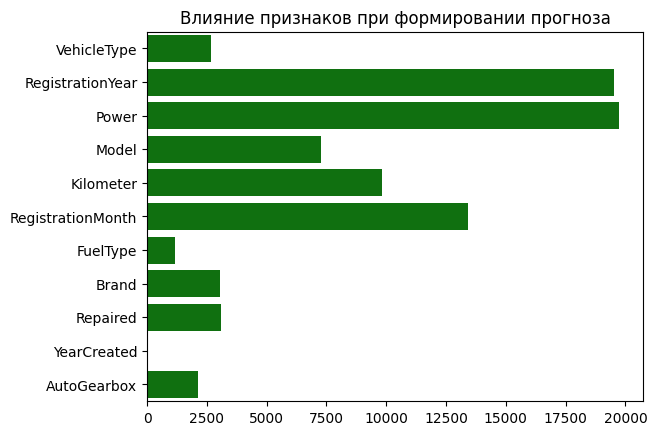

In [76]:
sns.barplot(data = df_feature_importances,orient ='h',
                color = 'green')

plt.title("Влияние признаков при формировании прогноза")

plt.show()

Мы видим, что признак год создания объявления никак не повнилял на стоимость
Наибольшее влияние на стоимость имеют год регистрации, мощность. Далее на очереди идёт месяц регистрации и пробег

## Выводы <a id="section4"></a>

- Предобработка
    - В данных не было линейной зависимости
    - Были обнаружены и удалены дубликаты
    - Присутствовали неадекватные значения, такие как год выпуска и мощность. Были заменены 
    - Для стандартных моделей была проведена стандартизация данных

- Были обучены четыре модели
    - ElasticNet. Линейная регрессия с регуляризацией. Сработала быстро, но некачественно
    - Случайный лес. В целом показал неплохие результаты. На уровне с плохо обученной CatBoost
    - LightGBM. Средняя скорость предсказания, не смотря на высокую точность и высокую скорость обучения
    - Catboost. Обучена хорошо, но потратил мало времени на обучение. Скорее всего будет превосходить и по скорости и по точности другие модели
    
- Лучшая модель - **LightGBM**